# **GeolifePrj_03_clustering.ipynb**
>## Usamos los archivos pickle _**geolife_xxx_features.zip**_ del Notebook 
>## **GeolifePrj_02_extrafeatures.ipynb** para plotear, hacer clustering 
>## y otras estadísticas


#### Algunos imports

In [86]:
import geopandas
import numpy as np
import pandas as pd
#from shapely.geometry import Point
from geojson import  Point,Feature, FeatureCollection, dumps
from datetime import timedelta, datetime
import csv, json

import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

from collections import OrderedDict

from shapely.geometry import LineString
from shapely.geometry import Point

from dateutil.parser import parse as parsedt

#### constantes para tagear los puntos geojson y crear colores

In [87]:
mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 
              'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_marker = ['pitch', 'bicycle', 'bus', "car", 'rail-underground','rail', 
              'airport', 'ferry', 'pitch', 'scooter', 'car']
mode_color = ['#f16f04', '#1ac16b', '#68aa31', '#8043b1', '#29c6db','#470e53', 
              '#595454', '#2026d5', '#f16f04', '#e52315', '#f6fa00']

mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}
mode_marker_dict = {i + 1:s for i, s in enumerate(mode_marker)}
mode_color_dict = {i + 1:s for i, s in enumerate(mode_color)}

cmaps = {}
cmaps['Uniform'] = [ 'viridis', 'plasma', 'inferno', 'magma', 'cividis','spring','summer','autumn','winter']
cmaps['Diverging'] = [ 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']
cmaps['Miscellaneous'] = [ 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']

cmap = plt.get_cmap(cmaps['Uniform'][0])
colors.to_hex(cmap(255))

'#fde725'

#### Probamos ver a que corresponde el valor **label**=4 (=modo de transporte)

In [88]:
label = 4
mode_names[label-1], mode_marker_dict[label] , mode_color_dict[label]

('car', 'car', '#8043b1')

## def **plot_evolucion_features(**df , start_dt, end_dt,...):
>### Plotea la columna 'vel' vs 'time' y otras estadísticas del **DataFrame** df ( DataFrame creado con **df=read_df_add_features(** *pickle_file* ,...**)** )

In [89]:
def plot_evolucion_features( df,start_dt , end_dt , vel='vel', acc='',tit="Evolucion de velocidad"):
    #muestra velocidad a través del tiempo
    if not isinstance(start_dt, datetime):
        start_dt = parsedt(start_dt)
    if not isinstance(end_dt, datetime):
        end_dt = parsedt(end_dt)
    
    df.reset_index(inplace=True,drop=True)
    f=plt.figure(figsize=(20,10))
    plt.xlabel(f'TIEMPO: del  {start_dt}  al  {end_dt}', fontsize=16)
    plt.ylabel('VELOCIDAD [km/h]', fontsize=16)
    df = df.loc[(df.time > start_dt) & (df.time < end_dt)]
    if(len(df)==0):
        f.suptitle("No hay datos en este rango de fechas!", fontsize=26)
    else:
        f.suptitle(tit, fontsize=26)        

    init1=int(df.index[0])
    end1=int(df.index[len(df)-1])
    rangotiks=range(init1,end1,round((end1-init1)/20+1))
    rangolabels = list(df.loc[df.index.isin(rangotiks), 'time'])
    plt.xticks(ticks=rangotiks, labels=rangolabels,  rotation=90)   
    
    lh=[]
    l1,=plt.plot(df[vel] , 'b' , label=vel)
    lh.append(l1)
    #l2,=plt.plot(df.velMA, 'ro' , label='velocidad MAvg')     
    #lh.append(l2)
    l4,=plt.plot(df.velMA3, 'yo' , label='velocidad MAvg3')  
    lh.append(l4)       
    """
    l3,=plt.plot(df.velMA2, 'g' , label='velocidad MAvg2')    
    lh.append(l3) 
    l5,=plt.plot(df.pruebas, 'k' , label='pruebas')    
    lh.append(l5)  
    """
    l6,=plt.plot(df.vel_label, 'c' , label='vel_label') 
    lh.append(l6)
    if acc!='':
        l7,=plt.plot(df[acc] , 'm', label=acc)
        lh.append(l7)
    
    plt.legend(handles=lh)

## Plot Evolucion de features por trayectorias con 
## def **muestra_trayectorias(**_trayect_inicio,trayect_fin,undersample_**):**
>### primera_trayectoria=
>### ultima_trayectoria=
>### under_sample_factor =  (cada cuantos puntos son tomados en cuenta)

In [92]:
### Calcula inicio y fin de trayectorias de **df** (cada trayectoria equivale a la data de un solo archivo .plt original)
start_ix=df.loc[df.idx_traj==0].index.tolist()
end_ix = [ i-1 for i in start_ix[1:]]
end_ix.append(len(df)-1)
for i in range(len(start_ix)):
    s_str=df.loc[start_ix[i],'time']
    e_str=df.loc[end_ix[i],'time']
    print("Trayectoria:",i,":",s_str," <--> ",e_str,f"({end_ix[i]-start_ix[i]} coordenadas)" )
    
def muestra_trayectorias(desde=1,hasta=5,usample=2):
    print("Undersample: ",usample)
    primera_trayectoria=desde
    ultima_trayectoria=hasta
    under_sample_factor = usample
    for trayectoria,rangodt in [ (idx, x) for idx,x in enumerate(zip(start_ix,end_ix)) if idx in range(primera_trayectoria,ultima_trayectoria+1)] : 
        s_str=df.loc[rangodt[0],'time']
        e_str=df.loc[rangodt[1],'time']
        titulo=f"Velocidad en el tiempo. Trayectoria: #{trayectoria} ({round((rangodt[1]-rangodt[0])/under_sample_factor)} puntos)"
        print(f"Trayectoria {trayectoria}/{len(start_ix)}:" ,s_str," <--> ",e_str)
        plot_evolucion_features(df.iloc[::under_sample_factor,:],s_str,e_str, vel='velprep2',acc='pruebas' ,tit=titulo)

Trayectoria: 0 : 2009-02-01 02:45:58  <-->  2009-02-01 07:58:55 (2298 coordenadas)
Trayectoria: 1 : 2009-02-01 22:48:28  <-->  2009-02-02 03:56:06 (13576 coordenadas)
Trayectoria: 2 : 2009-02-03 05:35:04  <-->  2009-02-03 12:42:43 (3779 coordenadas)
Trayectoria: 3 : 2009-02-04 07:23:34  <-->  2009-02-04 08:49:02 (4773 coordenadas)
Trayectoria: 4 : 2009-02-05 01:57:34  <-->  2009-02-05 06:02:44 (14316 coordenadas)
Trayectoria: 5 : 2009-02-06 00:52:04  <-->  2009-02-06 07:35:09 (2001 coordenadas)
Trayectoria: 6 : 2009-02-07 04:13:28  <-->  2009-02-07 09:35:23 (1070 coordenadas)
Trayectoria: 7 : 2009-02-08 00:14:03  <-->  2009-02-08 09:54:51 (1181 coordenadas)
Trayectoria: 8 : 2009-02-09 09:11:04  <-->  2009-02-09 15:36:05 (4016 coordenadas)
Trayectoria: 9 : 2009-02-10 08:54:03  <-->  2009-02-10 11:04:57 (753 coordenadas)
Trayectoria: 10 : 2009-02-10 23:34:28  <-->  2009-02-11 01:02:30 (1513 coordenadas)
Trayectoria: 11 : 2009-02-12 00:04:34  <-->  2009-02-12 04:40:50 (1671 coordenadas)
T

## Cargamos un **DataFrame df**=pd.read_pickle(_**geolife_xxx_features.zip**_) 

In [93]:
xxx=36
archivo_df = f"geolife_{xxx:03d}_features.zip"
df = pd.read_pickle(archivo_df)

>### Mostramos unas trayectorias

Undersample:  2
Trayectoria 2/72: 2009-02-03 05:35:04  <-->  2009-02-03 12:42:43
Trayectoria 3/72: 2009-02-04 07:23:34  <-->  2009-02-04 08:49:02
Trayectoria 4/72: 2009-02-05 01:57:34  <-->  2009-02-05 06:02:44


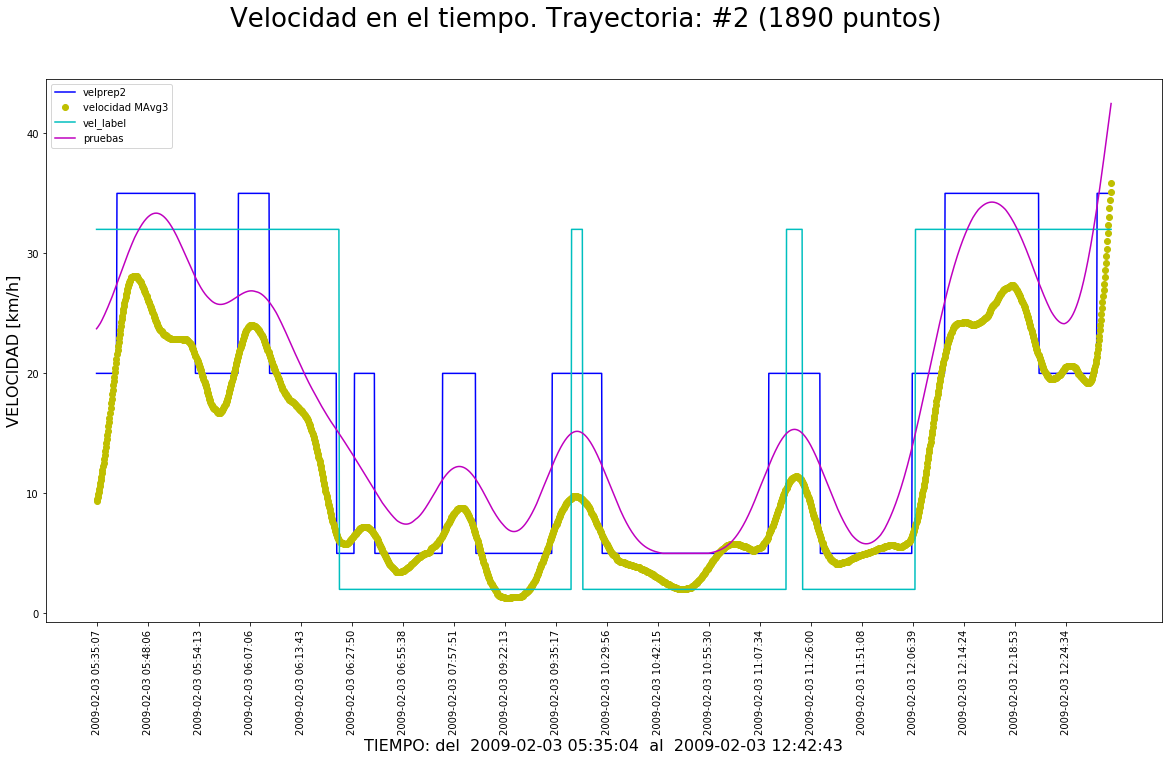

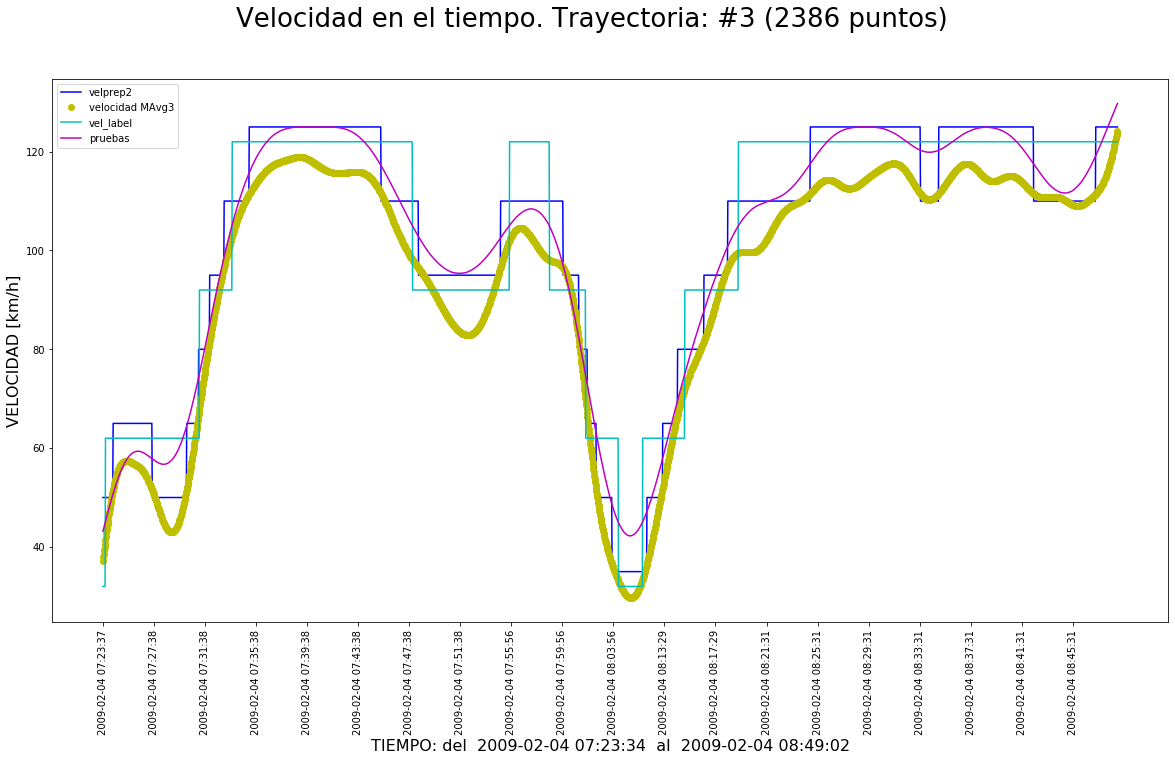

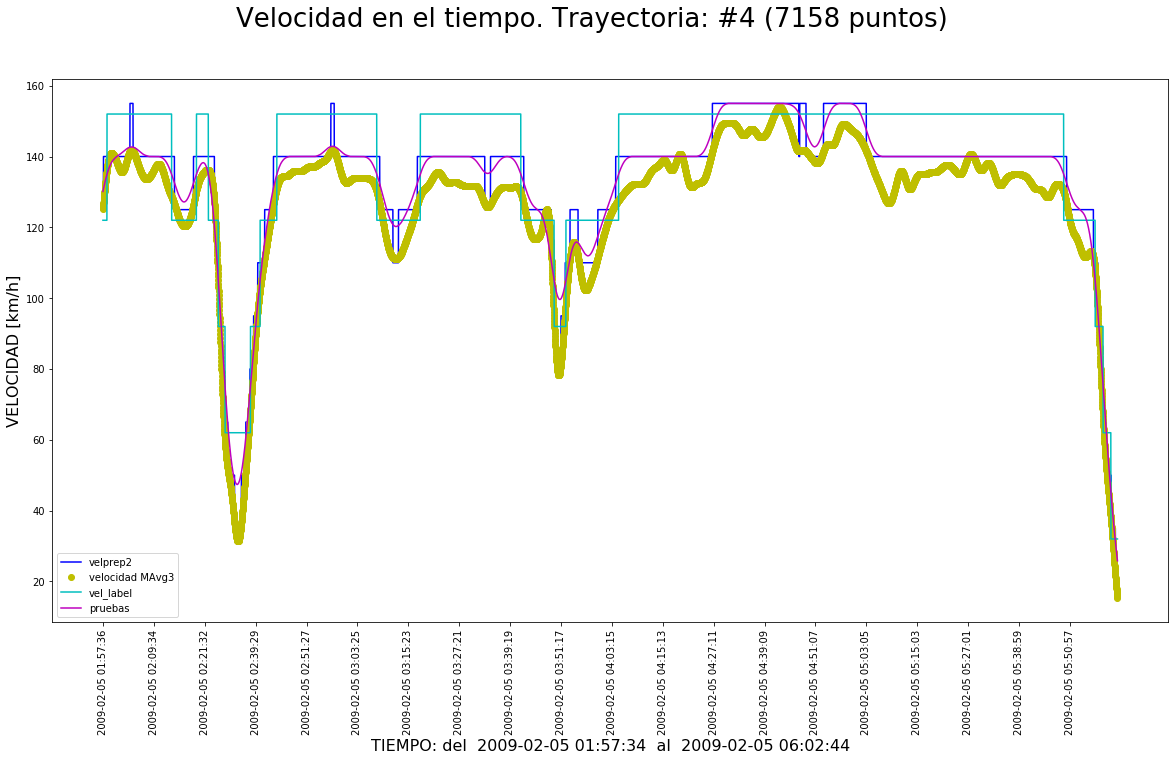

In [95]:
muestra_trayectorias(2,4,2)

>### Mostramos distribucion de velocidades de **df.vel**

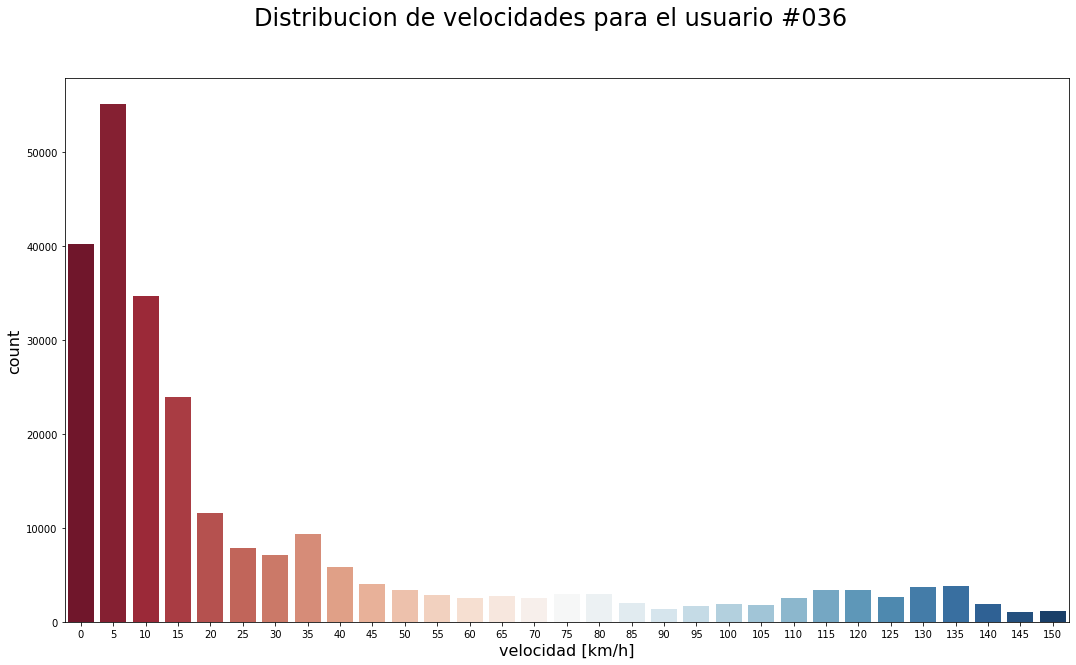

In [96]:
#ponemos la data en bins de ancho_bin
ancho_bin=5
l=[e if e<150 else 150 for e in list(df.vel.apply(lambda x:ancho_bin*round(x/ancho_bin))) ]

f=plt.figure(figsize=(18,10))
f.suptitle(f'Distribucion de velocidades para el usuario #{df.user[0]:03d}', fontsize=24)
plt.xlabel('velocidad [km/h]', fontsize=16)
plt.ylabel('features', fontsize=16)
sns.countplot(l , palette="RdBu")

# Hacemos **clustering** con **df**="geolife_xxx_features.zip"

>### Preparamos la data

In [120]:
#extraido de   https://yidatao.github.io/2016-12-23/geolife-dbscan/
xxx=39
archivo_df = f"geolife_{xxx:03d}_features.zip"
print("Cargando ",archivo_df)
df = pd.read_pickle(archivo_df)
df_min = df.iloc[::12, :]

df_min

Cargando  geolife_039_features.zip


,time,lat,lon,alt,label,user,idx_traj,vel,velMA,velprep,velMA2,velMA3,velprep2,pruebas,vel_label
0,2009-02-11 09:59:38,39.892864,116.455100,490,0,39,0,8.29,16.129444,8.29,11.367448,9.383440,20.0,20.000000,32.0
12,2009-02-11 10:00:38,39.892253,116.453925,515,0,39,12,4.95,6.427656,4.95,8.700929,9.514666,20.0,20.000000,32.0
24,2009-02-11 10:01:38,39.891293,116.453978,635,0,39,24,4.64,7.192344,4.64,9.047518,9.667373,20.0,20.000000,32.0
36,2009-02-11 10:37:51,39.974696,116.361925,412,0,39,36,9.86,16.610313,9.86,10.463105,10.008414,20.0,19.953779,32.0
48,2009-02-11 10:38:51,39.975146,116.363555,128,0,39,48,5.83,4.091250,5.83,7.029759,10.526086,20.0,19.863986,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267684,2009-07-15 00:15:06,40.003697,116.411666,418,0,39,387,52.94,66.858437,52.94,57.685761,38.264045,50.0,39.849714,32.0
267696,2009-07-15 00:52:56,39.892890,116.453264,541,0,39,399,1.14,14.878906,1.14,28.396397,36.534791,50.0,40.491974,32.0
267708,2009-07-15 00:53:56,39.893543,116.453579,549,0,39,411,3.49,4.458438,3.49,7.788810,34.567286,35.0,41.049345,32.0
267720,2009-07-15 00:54:51,39.893724,116.453462,535,0,39,423,7.12,5.613906,7.12,6.229388,31.840715,35.0,41.492098,32.0


>### aplicamos DBSCAN

In [121]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# represent GPS points as (lat, lon)
#coords = df_min.as_matrix(columns=['lat', 'lon'])
coords = df_min[['lat','lon']].astype(float).to_numpy()
#x =np.array(l2d)

# earth's radius in km
kms_per_radian = 6371.0088
# define epsilon as 0.5 kilometers, converted to radians for use by haversine
epsilon = 0.5 / kms_per_radian

# eps is the max distance that points can be from each other to be considered in a cluster
# min_samples is the minimum cluster size (everything else is classified as noise)
db = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
# get the number of clusters (ignore noisy samples which are given the label -1)
num_clusters = len(set(cluster_labels) - set([-1]))

print( 'Clustered ' + str(len(df_min)) + ' points to ' + str(num_clusters) + ' clusters' )

# turn the clusters in to a pandas series
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
clusters

Clustered 22312 points to 16 clusters


0     [[39.892864, 116.4551], [39.892253000000004, 1...
1     [[39.974696, 116.361925], [39.975146, 116.3635...
2     [[39.980429, 116.29954599999999], [39.980441, ...
3     [[40.028599, 116.342525], [40.029519, 116.3419...
4     [[39.888493, 116.34070700000001], [39.888277, ...
5     [[39.88257, 116.392592], [39.881324, 116.39259...
6     [[39.975312, 116.483617], [39.971819, 116.4837...
7     [[40.036721, 116.333063], [40.03481, 116.32771...
8     [[40.020879, 116.41273799999999], [40.0727, 11...
9     [[40.371812, 115.89601599999999], [40.375398, ...
10    [[40.027173, 116.311039], [40.024821, 116.3074...
11    [[40.36012, 116.67751499999999], [40.36159, 11...
12    [[40.065421, 116.55868000000001], [40.06425, 1...
13    [[39.791669, 116.523494], [39.788205, 116.5230...
14    [[40.055979, 116.296388], [40.052739, 116.2979...
15    [[39.888431, 116.24448799999999], [39.888446, ...
dtype: object

In [122]:
a=0
for i in range(15):
    a=a+len(clusters[i])
a

16878

In [123]:
from shapely.geometry import MultiPoint
from geopy.distance import great_circle

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

# get the centroid point for each cluster
centermost_points = clusters.map(get_centermost_point)
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

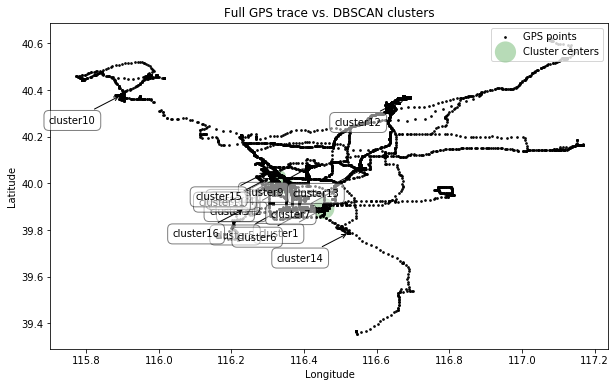

In [124]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['lon'][0], rep_points['lat'][0], c='#99cc99', edgecolor='None', alpha=0.7, s=450)
ax.scatter(rep_points['lon'][1], rep_points['lat'][1], c='#99cc99', edgecolor='None', alpha=0.7, s=250)
ax.scatter(rep_points['lon'][2], rep_points['lat'][2], c='#99cc99', edgecolor='None', alpha=0.7, s=250)
ax.scatter(rep_points['lon'][3], rep_points['lat'][3], c='#99cc99', edgecolor='None', alpha=0.7, s=150)
df_scatter = ax.scatter(df_min['lon'], df_min['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full GPS trace vs. DBSCAN clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['GPS points', 'Cluster centers'], loc='upper right')

labels = ['cluster{0}'.format(i) for i in range(1, num_clusters+1)]
for label, x, y in zip(labels, rep_points['lon'], rep_points['lat']):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-25, -30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

In [126]:
# Get the hours for each cluster
M = []
def myfunc(row):
    t = df_min[(df_min['lat']==row[0]) & (df_min['lon']==row[1])]['time'].iloc[0]
    return t[:t.index(':')]
for i in range(num_clusters):
    hours = np.apply_along_axis(myfunc, 1, clusters[i]).tolist()
    M.append(map(int, hours))

AttributeError: 'Timestamp' object has no attribute 'index'